# Sparkify Project

**Project Overview:** Sparkify is a digital music service similar to Spotfiy and Pandora. In Sparkify, users can either listen to music for free or buy a subscription. Customer churn prevention is a hot and challenging problem in almost every product and service company. If companies were able to utilize customer-usage data to find unique trends and accurately map them to indicate which customers may churn, it would be possible to incentivize customers to remain using their services giving them a loyal customer base which is key for a company’s growth.

**Project Purpose:** In order to identify users who are likely to churn, it’s important to perform an exploratory analysis to glean insights from the data set and identify key variables of interest. The next process is to experiment different model algorithms and then select the best model based on key evaluation metric such as F1 Score and accuracy using Spark ML Library.

**Data**
The data we have from Sparkify is that of user events. Every interaction of every user with the application is given to us. This means every time a user goes to the Home page, listens to a song, thumbs up a song, etc. we have an event in the data corresponding to the same.

### Solution expectation and machine learning models:
The expectation is that some of these features will reveal a substantial difference between customers that churn versus those that don't. This information is used to create useful features for a classification model for churn. We will experiment using models such as Logistic regression, random forest, gradient boosting, and decision tree to evaluate the problem.

**Metrics:** 
The classification model is evaluated using standard metrics for binary output data - accuracy and F1-score. F1-score is given greater importance from an interpretation perspective due to imbalanced nature of the output data (significantly fewer customers churn than don't). Accuracy only works well when the dataset classes are balanced

# Table of Content

Target: Predict users at risk to churn either downgrade from premium to free tier or cancelling their services altogether.

1. Load and Clean Dataset
2. Exploratory Data Analysis.
3. Feature Engineering.
4. Model Training and Prediction.

#### Import Libraries

In [21]:
# Import libraries
import pyspark
from pyspark import SparkConf
from pyspark.sql import SparkSession

from pyspark.sql import SparkSession, Window
from pyspark.sql.functions import avg, stddev, isnan, split, udf, isnull, first, col, format_number, rand, countDistinct,count, trim, desc, countDistinct, expr, min, max
from pyspark.sql.functions import min as fmin
from pyspark.sql.functions import max as fmax
from pyspark.sql.functions import sum as fsum
from pyspark.sql.types import IntegerType, FloatType, StringType

import pyspark.sql.functions as f

from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression, DecisionTreeClassifier,RandomForestClassifier, LinearSVC, GBTClassifier
from pyspark.ml.feature import StringIndexer, OneHotEncoder, StandardScaler, VectorAssembler, Normalizer, MinMaxScaler, VectorAssembler, HashingTF
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

import re
import copy
import time
import datetime
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

#### Create a SparkSession for using spark and name it "Sparkify".

In [22]:
# Create a Spark session
spark = SparkSession \
    .builder \
    .appName('Sparkify') \
    .getOrCreate()

# Load and Clean Dataset
The following steps will be processed with subset of a 12GB dataset named `mini_sparkify_event_data.json`. First of all the dataset the dataset will be loaded, cleaned and checked for invalid or missing data.

In [23]:
# Read json data
sparkify_data = 'mini_sparkify_event_data.json'
df = spark.read.json(sparkify_data)

In [24]:
# Show all columns and data types
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [25]:
# Select and show statistcs for several items 
for col in df.schema:    
    if str(col.name) in ['artist','auth','gender','level' ,'location','page']:
        df.groupBy(str(col.name)).count().show() # Understand the meaning of columns

+--------------------+-----+
|              artist|count|
+--------------------+-----+
|      The Black Keys| 1125|
|         Silverstein|   60|
|           Kate Nash|   99|
|        Yann Tiersen|  139|
|    Jane's Addiction|   68|
|          Tim Hughes|   39|
|          Carl Craig|    3|
|Dashboard Confess...|   98|
|Yonder Mountain S...|   63|
|           Los Lobos|   45|
|Pete Rock & C.L. ...|    2|
|        Ziggy Marley|   28|
|      Jarabe De Palo|   83|
|               Rufio|   13|
|WC And The Maad C...|    1|
|      Jorge Gonzalez|   24|
|                Silk|   22|
|  The Watts Prophets|    6|
|            La Shica|    2|
|        Generation X|   19|
+--------------------+-----+
only showing top 20 rows

+----------+------+
|      auth| count|
+----------+------+
|Logged Out|  8249|
| Cancelled|    52|
|     Guest|    97|
| Logged In|278102|
+----------+------+

+------+------+
|gender| count|
+------+------+
|     F|154578|
|  null|  8346|
|     M|123576|
+------+------+

+---

In [26]:
# Check for null values 
for i in df.columns:
    print(i, ':', df.filter(df[i].isNull()).count())

artist : 58392
auth : 0
firstName : 8346
gender : 8346
itemInSession : 0
lastName : 8346
length : 58392
level : 0
location : 8346
method : 0
page : 0
registration : 8346
sessionId : 0
song : 58392
status : 0
ts : 0
userAgent : 8346
userId : 0


In [27]:
# Total sessions after removing duplicates based on user and session id
df = df.dropna(how = "any", subset = ["userId", "sessionId"])
df.count()

286500

In [28]:
# Total number of sessions after removing blank user id 
df = df.filter(df["userId"] != "")
df.count()

278154

In [29]:
# Number of unique users in dataset
user_ids = df.select('userId').dropDuplicates().count()
print('The number of unique users in dataset: ' + str(user_ids))

# Number of unique session ids
session_ids = df.select('sessionId').dropDuplicates().count()
print('The number of unique session ids: ' + str(session_ids))

# Number of unique pages
pages = df.select('page').dropDuplicates().count()
print('The number of unique pages: ' + str(pages))

The number of unique users in dataset: 225
The number of unique session ids: 2312
The number of unique pages: 19


# Exploratory Data Analysis (EDA)
“Churn” label is generated from the dataset by identifying users who confirm their subscription cancellation. Once churned users are identified, we can view how it behaves with other features in the dataset. We will be exploring the data to see trends and features that may influence the churn rate.

### Define Churn
- Create a churn label column for the dataset. It returns 1 if Cancellation Confirmation events happens

In [30]:
# Churn Definition
churn_def = udf(lambda x: 1 if x == "Cancellation Confirmation" else 0, IntegerType())
# Apply to the dataframe
df = df.withColumn("churn", churn_def("page"))
# Define window bounds
windowval = Window.partitionBy("userId").rangeBetween(Window.unboundedPreceding, Window.unboundedFollowing)
# Applying the window
df = df.withColumn("churn", fsum("churn").over(windowval))

### Distribution of Users by Churn Type
- There are 225 total users, 52 users were identified to be churned; this is approxiately 24% of the universe.

In [31]:
# Distribution of users by Churn Type
churn_count = df.groupBy("Churn").agg(countDistinct("userId").alias("Users"))
churn_count_pd = churn_count.toPandas() # Create churn count dataframe
churn_count.show()

+-----+-----+
|Churn|Users|
+-----+-----+
|    0|  173|
|    1|   52|
+-----+-----+



Text(0, 0.5, 'Number of Users')

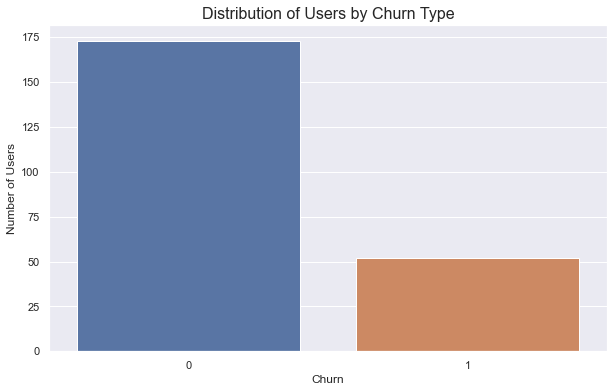

In [32]:
# Distribution of users by Churn Type Plot
sns.set_theme(style="darkgrid")
plt.figure(figsize=(10, 6))
plt.title("Distribution of Users by Churn Type", fontsize= 16)
sns.barplot(x='Churn', y='Users', data= churn_count_pd)
plt.xlabel("Churn")
plt.ylabel("Number of Users")

### Churn per Gender
- We have more male users (~54% male, ~46% female) in our dataset so it’s no surprise that we’d have more male users who churn. The churn rate for males is quite higher than females (26% vs 19%).

In [33]:
# Churn per gender plot
churn_gender_pd = df.filter(df.page == 'Cancellation Confirmation').select(['userId', 'gender']).drop_duplicates().groupby('gender').count().toPandas()
churn_gender_pd['Churn'] = True
nonchurn_gender_pd = df.filter(df.page != 'Cancellation Confirmation').select(['userId', 'gender']).drop_duplicates().groupby('gender').count().toPandas()
nonchurn_gender_pd['Churn'] = False
churn_gender = pd.concat([churn_gender_pd, nonchurn_gender_pd], sort=False, ignore_index=True)
churn_gender.head()

,gender,count,Churn
0,F,20,True
1,M,32,True
2,F,104,False
3,M,121,False


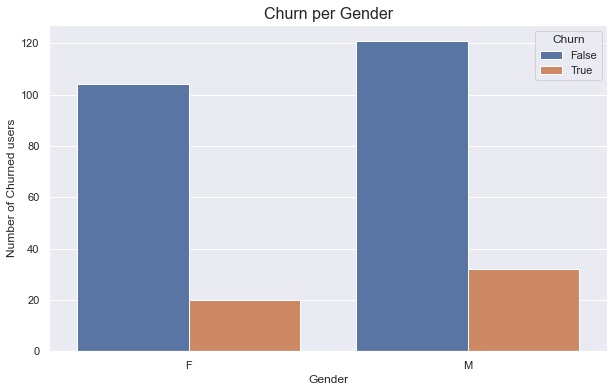

In [34]:
# Plot churn per gender
plt.figure(figsize=(10, 6))
plt.title('Churn per Gender', fontsize=16)
sns.barplot(x='gender', y='count', hue='Churn', data=churn_gender)
plt.xlabel('Gender', fontsize=12)
plt.ylabel('Number of Churned users', fontsize=12)
plt.show()

In [35]:
# Create a temporary view to perform SQL operations
df.createOrReplaceTempView("df_sqlsparkify")

In [36]:
# Create DataFrame for total user in location
location_df = spark.sql("""
                           SELECT location, 
                                  Count(DISTINCT userid) AS total_user 
                           FROM   df_sqlsparkify
                           GROUP  BY location 
                           ORDER BY total_user
                           DESC
                           """).toPandas()

In [37]:
# Create DataFrame for churn user in location
location_churn_df = spark.sql("""
                                 SELECT location, 
                                        Count(DISTINCT userid) AS churn_user 
                                 FROM   df_sqlsparkify
                                 WHERE  churn=1
                                 GROUP BY location
                                 """).toPandas()

In [38]:
# Merge DataFrame and add percentage column
merge_df = location_churn_df.merge(location_df, on="location").sort_values(by="total_user", ascending=False)
merge_df["percentage"] = merge_df["churn_user"] / merge_df["total_user"] * 100
merge_df.sort_values(by="percentage", ascending=False).head(20)

,location,churn_user,total_user,percentage
38,"Flint, MI",2,2,100.0
18,"Oxnard-Thousand Oaks-Ventura, CA",1,1,100.0
29,"Quincy, IL-MO",1,1,100.0
0,"Cleveland-Elyria, OH",1,1,100.0
20,"Monroe, LA",1,1,100.0
27,"North Wilkesboro, NC",1,1,100.0
23,"Bozeman, MT",1,1,100.0
21,"Little Rock-North Little Rock-Conway, AR",1,1,100.0
17,"Memphis, TN-MS-AR",1,1,100.0
32,"Lexington-Fayette, KY",1,1,100.0


### Churn vs Total User in Location
- The locations with the highest total users and churn users are in ‘Los Angelos-Long Beach-Anaheim, CA’, ‘New York-Newark-Jersey City, NY-NJ-PA’, and ‘Phoenix-Mesa-Scottsdale, AZ’. User locations are scattered widely and are rather sparse in almost all locations.

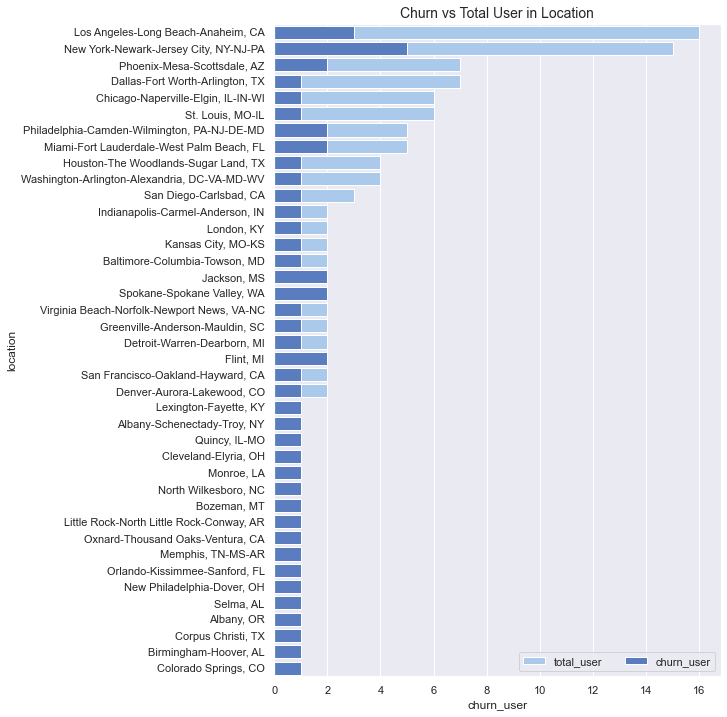

In [39]:
fig, ax = plt.subplots(figsize=(8, 12))
plt.title("Churn vs Total User in Location", fontsize=14)
sns.set_color_codes("pastel")
sns.barplot(x="total_user", y="location", data=merge_df, ax=ax,
            label="total_user",color="b")

sns.set_color_codes("muted")
sns.barplot(x="churn_user", y="location", data=merge_df, ax=ax, 
            label="churn_user",color="b")
ax.legend(ncol=2, loc="lower right", frameon=True)

### Churn vs Non-churn User per Device
- We can see that most users use Windows or Mac to access the service, which also have the most customer churn. The churn rate for Windows users is 18.5% which is slightly higher than Mac sitting at 18.1%. Devices such as X11 and iPhone have a much lower user base resulting in lower churn amount.

In [40]:
get_device = udf(lambda x: x.split('(')[1].replace(";", " ").split(" ")[0])
df_devices = df.withColumn('Device', get_device('userAgent'))

print('Churn User per device')
df_devices.filter(df.page == 'Cancellation Confirmation').select(['userId', 'Device']).drop_duplicates().groupby('Device').count().show()

print('Non-churn User per device')
df_devices.filter(df.page != 'Cancellation Confirmation').select(['userId', 'Device']).drop_duplicates().groupby('Device').count().show()

Churn User per device
+---------+-----+
|   Device|count|
+---------+-----+
|      X11|    5|
|   iPhone|    4|
|Macintosh|   19|
|  Windows|   24|
+---------+-----+

Non-churn User per device
+----------+-----+
|    Device|count|
+----------+-----+
|      iPad|    3|
|       X11|   12|
|    iPhone|   13|
| Macintosh|   86|
|compatible|    5|
|   Windows|  106|
+----------+-----+



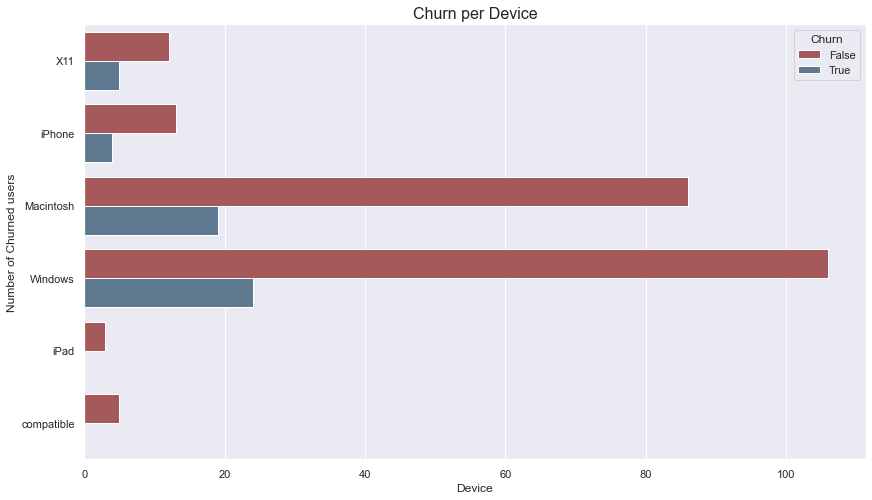

In [41]:
# Churn per device plot
churn_device_pd = df_devices.filter(df_devices.page == 'Cancellation Confirmation').select(['userId', 'Device']).drop_duplicates().groupby('Device').count().toPandas()
churn_device_pd['Churn'] = True
nonchurn_device_pd = df_devices.filter(df_devices.page != 'Cancellation Confirmation').select(['userId', 'Device']).drop_duplicates().groupby('Device').count().toPandas()
nonchurn_device_pd['Churn'] = False
churn_device = pd.concat([churn_device_pd,nonchurn_device_pd], sort=False, ignore_index=True)

# Plot
plt.figure(figsize=(14,8))
sns.set_palette("Set1",n_colors=8, desat=.5)
sns.barplot(x='count', y='Device', hue='Churn', data=churn_device)
plt.xlabel('Device', fontsize=12)
plt.ylabel('Number of Churned users', fontsize=12)
plt.title('Churn per Device', fontsize=16)
plt.show()

### Distribution of Page and Churn Users
- Pages such as ‘Next Song’, ‘Thumbs Up’, ‘Add Friend’, and ‘Add to Playlist’ have a higher proportion of non-churn users. Finding the number of users visit these pages may determine if the users are likely to churn or not.

In [42]:
page_churn_df = spark.sql("""
                    SELECT page,
                           churn,
                           COUNT(DISTINCT(userId)) AS total_user
                    FROM   df_sqlsparkify
                    GROUP BY page,
                             churn
                    """).toPandas()

In [43]:
def sns_barplot_text(x, y, data, title, hue=None, percentage=True, text=True,
                     log=False, figsize=(8, 5)):
    """
    Similar to sns.barplot but added text option for the bar
    """
    fig, ax = plt.subplots(figsize=figsize)
    sns.barplot(x=x, y=y, data=data, hue=hue, ax=ax, log=log)
    ax.set_xlabel(f"{data.columns[0]}")
    ax.set_title(title)
    ax.set_xticklabels(data.loc[:,x].unique(), rotation=90)
    if text:
        for p in ax.patches:
                height = p.get_height()
                if percentage:
                    ax.text(p.get_x() + p.get_width() / 2.,
                            height,
                            f"{height /data.loc[:,y].sum() * 100 :.2f}%",
                            ha="center", fontsize=8)
                else:
                    ax.text(p.get_x() + p.get_width() / 2.,
                            height,
                            f"{height :.2f}",
                            ha="center", fontsize=8)

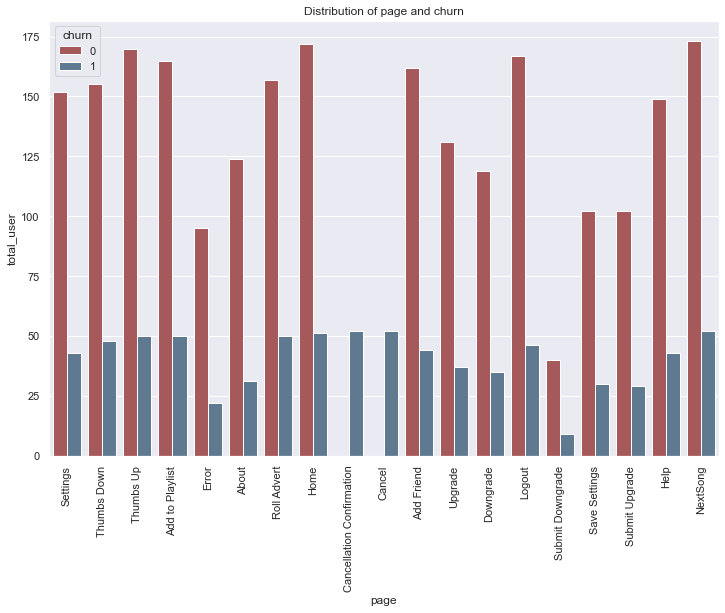

In [44]:
sns_barplot_text(x="page", y="total_user", data=page_churn_df, hue="churn",
                 title="Distribution of page and churn", percentage=False,
                 text=False, figsize=(12, 8))

# Feature Engineering

After exploratory data analysis, 10 features hypothetically assumed to influence determining user churn were engineered. Following that, feature importance as a result of model training will determine what model and features to be adopted for full dataset modelling.

### Features Selected to be used for modeling

The following Features will be created at user level:

1.  gender: gender of the user. Male = "1", Female = "0" [binary]
2.  churn: a page for 'Cancel Confirmation' defined as churn. Churn = "1", Absence of churn = "0" [binary]
3.  level: latest level of a user. paid = "1", free = "0" [binary]
4.  length: user total length of songs listened [float]
5.  avg_session_duration: user average session duration [float]
6.  page: number visits per page feature - Add friend, Add to Playlist, Downgrade, Error, Help, Home, etc..  [int]
7.  time_since_reg: time since registration [int]
8.  sessions: total number of sessions [int]
9. songs: total number of songs played [int]
10. userAgent: agents/device used by the user [binary]

In [78]:
# Load data for feature engineering
df = spark.read.json('mini_sparkify_event_data.json')

# Drop rows with missing user id
df = df.where(df.userId != '')

#### 1. gender(binary)
- Binarize gender feature for machine learning algorithms, Male = "1", Female = "0"

In [79]:
# User defined function for gender
get_gender = udf(lambda x: 1 if x == 'M' else 0, IntegerType())

# Feature for gender
gender = df.withColumn('gender', get_gender('gender')).select(['userId','gender']).groupby('userId').agg(max('gender').alias('gender'))
gender.show(5)

+------+------+
|userId|gender|
+------+------+
|100010|     0|
|200002|     1|
|   125|     1|
|    51|     1|
|   124|     0|
+------+------+
only showing top 5 rows



#### 2. churn (binary)
- This feature indicates if the user churned or not, target feature

In [80]:
# User defined function for churn
get_churn = udf(lambda x: 1 if x == 'Cancellation Confirmation' else 0, IntegerType())

# Feature for churn
churn = df.withColumn('churn', get_churn('page')).select(['userId','churn']).groupby('userId').agg(max('churn').alias('churn'))
churn.show(5)

+------+-----+
|userId|churn|
+------+-----+
|100010|    0|
|200002|    0|
|   125|    1|
|    51|    1|
|   124|    0|
+------+-----+
only showing top 5 rows



#### 3.  level (binary)
- Most recent level of a user, paid = 1, free = 0

In [81]:
# User defined function for level (paid=1, free=1)
get_level = udf(lambda x: 1 if x == 'paid' else 0, IntegerType())

# Feature for level
level = df.select(['userId', 'level', 'ts']).orderBy(desc('ts')).dropDuplicates(['userId']).select(['userId', 'level'])\
        .withColumn('level', get_level('level').cast(IntegerType()))

level.show(5)

+------+-----+
|userId|level|
+------+-----+
|100010|    0|
|200002|    1|
|   125|    0|
|   124|    1|
|    51|    1|
+------+-----+
only showing top 5 rows



#### 4.  length (float)
- Total time of songs the user has played, indicates how active they are.

In [82]:
# Feature for total lenth of songs played
length = df.select("userId", 'length').groupBy('userId').sum().withColumnRenamed('sum(length)', 'total_time')

length.show(5)

+------+------------------+
|userId|        total_time|
+------+------------------+
|100010|       66940.89735|
|200002| 94008.87593999993|
|   125|2089.1131000000005|
|    51| 523275.8428000004|
|   124|1012312.0927900008|
+------+------------------+
only showing top 5 rows



#### 5.  avg_session_duration (float)
- Average session duration for a user, may determine if the user is satisfied with the service

In [83]:
# Create Feature for avg session duration
avg_session_duration = df.select(['userId','sessionId','ts']).groupby(['userId','sessionId']).agg(avg('ts').alias('avg_session_duration'))
avg_session_duration = avg_session_duration.drop('sessionId')
avg_session_duration.show(5)

+------+--------------------+
|userId|avg_session_duration|
+------+--------------------+
|    92|1.538592785972602...|
|    42|1.538685408666666...|
|   101|1.539165263256140...|
|   120|1.539209327272030...|
|   140|1.539424855166666...|
+------+--------------------+
only showing top 5 rows



#### 6. page (int)
Page features
- Add Friend, Add to Playlist, Downgrade, Error, Help, Home, Logout, Nextsong, Roll Advert, Settings, Submit Downgrade, Thumbs Down, and Thumbs Up are features that may influence churn.

In [84]:
# User defined function
get_page = udf(lambda x: 'page_' + x.replace(' ', '_').lower())
exclude_page = ['Cancel', 'Cancellation Confirmation', 'Submit Upgrade', 'Save Settings', 'Upgrade', 'About']

# Create page features
page = df.filter(~df['page'].isin(exclude_page)).withColumn('page', get_page(df['page']))\
                 .groupBy(['userId']).pivot('page').agg(count('page')).fillna(0)

page.show(5)

+------+---------------+--------------------+--------------+----------+---------+---------+-----------+-------------+----------------+-------------+---------------------+----------------+--------------+
|userId|page_add_friend|page_add_to_playlist|page_downgrade|page_error|page_help|page_home|page_logout|page_nextsong|page_roll_advert|page_settings|page_submit_downgrade|page_thumbs_down|page_thumbs_up|
+------+---------------+--------------------+--------------+----------+---------+---------+-----------+-------------+----------------+-------------+---------------------+----------------+--------------+
|200002|              4|                   8|             5|         0|        2|       20|          5|          387|               7|            3|                    0|               6|            21|
|100010|              4|                   7|             0|         0|        2|       11|          5|          275|              52|            0|                    0|               5| 

#### 7.  time_since_reg (int)
- Time of user stayed with the service since registration

In [85]:
# Create feature for time since registration
df_reg_ts = df.select(['userId','registration']).groupby('userId').agg(min('registration').alias('reg_ts'))
df_max_ts = df.select(['userId','ts']).groupby('userId').agg(max('ts').alias('max_ts'))
time_since_reg = df_max_ts.join(df_reg_ts, on=['userId'])

# Calculate Delta of start-end
time_since_reg = time_since_reg.withColumn('time_since_reg', expr('max_ts - reg_ts'))
time_since_reg = time_since_reg.drop('max_ts')
time_since_reg = time_since_reg.drop('reg_ts')

time_since_reg.show(5)

+------+--------------+
|userId|time_since_reg|
+------+--------------+
|100010|    4807612000|
|200002|    6054448000|
|   125|    6161779000|
|   124|   11366431000|
|    51|    1680985000|
+------+--------------+
only showing top 5 rows



#### 8.  sessions (int)
- Total number of sessions per user, more sessions may indicate less likely to churn

In [86]:
# Create feature for session
sessions = df.select(['userId','sessionId']).dropDuplicates().groupby('userId').agg(count('sessionId').alias('sessions'))

sessions.show(5)

+------+--------+
|userId|sessions|
+------+--------+
|100010|       7|
|200002|       6|
|   125|       1|
|    51|      10|
|   124|      29|
+------+--------+
only showing top 5 rows



#### 9. songs (int)
- Total number of songs the user has played, identifies frequent users

In [87]:
# Create feature for songs
songs = df.select(['userId','song']).groupby('userId').agg(count('song').alias('songs'))

songs.show(5)

+------+-----+
|userId|songs|
+------+-----+
|100010|  275|
|200002|  387|
|   125|    8|
|    51| 2111|
|   124| 4079|
+------+-----+
only showing top 5 rows



#### 10. userAgent (binary)
- Type of device/agent the user is using

In [88]:
# User defined function
get_agent = udf(lambda x: x.split('(')[1].replace(";", " ").split(" ")[0])

# Create feature for device/useragent
userAgent = df.withColumn('userAgent', get_agent(df['userAgent'])).select(['userId', 'userAgent']).dropDuplicates(['userId'])\
            .groupBy('userId').pivot('userAgent').agg(count('userAgent')).fillna(0)

userAgent.show(5)

+------+---------+-------+---+----------+----+------+
|userId|Macintosh|Windows|X11|compatible|iPad|iPhone|
+------+---------+-------+---+----------+----+------+
|100010|        0|      0|  0|         0|   0|     1|
|200002|        0|      0|  0|         0|   0|     1|
|   125|        1|      0|  0|         0|   0|     0|
|   124|        1|      0|  0|         0|   0|     0|
|    51|        0|      1|  0|         0|   0|     0|
+------+---------+-------+---+----------+----+------+
only showing top 5 rows



### Merge Features
- Merge all built features together to prepare for modeling

In [89]:
# Merge features
df = gender.join(churn, ['userId'])\
           .join(level, ['userId'])\
           .join(length, ['userId'])\
           .join(avg_session_duration, ['userId'])\
           .join(page, ['userId'])\
           .join(time_since_reg, ['userId'])\
           .join(sessions, ['userId'])\
           .join(songs, ['userId'])\
           .join(userAgent, ['userId'])\
           .drop('userId')

# Modeling

In [90]:
df.printSchema()

root
 |-- gender: integer (nullable = true)
 |-- churn: integer (nullable = true)
 |-- level: integer (nullable = true)
 |-- total_time: double (nullable = true)
 |-- avg_session_duration: double (nullable = true)
 |-- page_add_friend: long (nullable = true)
 |-- page_add_to_playlist: long (nullable = true)
 |-- page_downgrade: long (nullable = true)
 |-- page_error: long (nullable = true)
 |-- page_help: long (nullable = true)
 |-- page_home: long (nullable = true)
 |-- page_logout: long (nullable = true)
 |-- page_nextsong: long (nullable = true)
 |-- page_roll_advert: long (nullable = true)
 |-- page_settings: long (nullable = true)
 |-- page_submit_downgrade: long (nullable = true)
 |-- page_thumbs_down: long (nullable = true)
 |-- page_thumbs_up: long (nullable = true)
 |-- time_since_reg: long (nullable = true)
 |-- sessions: long (nullable = false)
 |-- songs: long (nullable = false)
 |-- Macintosh: long (nullable = true)
 |-- Windows: long (nullable = true)
 |-- X11: long (null

### Split Data into Train and Test dataset

## Base models

* We fitted logistic regression, Random Forest Gradient boosting and Decision Tree classifier with default parameter. We'll look for f1 score and accuracy, however f1 score is more reliable in this case due to imbalance in class from accuracy. The table summarised the scores for these classifiers with default parameters.

| Classifier      | f1-score | accuracy |
| -------------   | ------:| -------:|
| Logistic Regression|0.86539|0.87685|
| Random Forest      |0.94284|0.94692|
| Gradient Boosting |0.99038|0.99044|
| Decision Tree|0.93170|0.93418|

With the default parameter, Gradient Boosting has the highest score of all the metrics and random forest comes second.

In [91]:
# Create train and test set
user_df = df.drop('userId') # drop userId col
features = [col for col in user_df.columns if col!='churn'] # all features except churn due to target prediction variable
train, test = user_df.randomSplit([0.7, 0.3], seed=42)
train = train.cache()

In [92]:
# Create pipeline model
def model_pipeline(classifier, params):
    """
    Build model pipline 
    input:
    classifier: type of classifier
    params: param grid
    output :
    ML pipeline model
    """
    assembler = VectorAssembler(inputCols=features, outputCol="features")
    scaler = MinMaxScaler(inputCol="features", outputCol="scaled_features")
    pipeline = Pipeline(stages=[assembler, scaler, classifier])

    model = CrossValidator(
        estimator=pipeline,
        estimatorParamMaps=params,
        evaluator = MulticlassClassificationEvaluator(labelCol='churn', metricName='f1'),
        numFolds=5,
    )
    return model

### Logistic Regression

In [93]:
# logistic regression 
m1 = LogisticRegression(featuresCol="scaled_features", labelCol="churn")
m1_param = ParamGridBuilder().build()
model_lr = model_pipeline(m1, m1_param)

In [94]:
fit_model_lr = model_lr.fit(train)

In [95]:
pred_lr = fit_model_lr.transform(test)

In [96]:
pred_lr.select("prediction").dropDuplicates().collect()
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction", labelCol="churn")
f1_score = evaluator.evaluate(pred_lr, {evaluator.metricName: "f1"})
accuracy = evaluator.evaluate(pred_lr, {evaluator.metricName: "accuracy"})

print("f1 using Logistic Regression: {}".format(f1_score))
print("accuracy using Logistic Regression: {}".format(accuracy))

f1 using Logistic Regression: 0.8653983401932132
accuracy using Logistic Regression: 0.8768577494692145


### Random Forest

In [97]:
# Random forest
m2 = RandomForestClassifier(featuresCol="scaled_features", labelCol="churn")
m2_param = ParamGridBuilder().build()
model_rf = model_pipeline(m2, m2_param)

In [98]:
fit_model_rf = model_rf.fit(train)

In [99]:
pred_rf = fit_model_rf.transform(test)

In [100]:
f1_score_rf = evaluator.evaluate(pred_rf, {evaluator.metricName: "f1"})
accuracy_rf = evaluator.evaluate(pred_rf, {evaluator.metricName: "accuracy"})

print("f1 using Random Forest: {}".format(f1_score_rf))
print("accuracy using Random Forest: {}".format(accuracy_rf))

f1 using Random Forest: 0.9428446652885956
accuracy using Random Forest: 0.9469214437367304


### Gradient Boost

In [101]:
# Gradient boost
gbt = GBTClassifier(featuresCol="scaled_features", labelCol="churn")
gbt_param = ParamGridBuilder().build()
gbt_model = model_pipeline(gbt, gbt_param)

In [102]:
gbt_fit_model = gbt_model.fit(train)
gbt_pred = gbt_fit_model.transform(test)
gbt_pred.select("prediction").dropDuplicates().collect()

[Row(prediction=0.0), Row(prediction=1.0)]

In [103]:
gbt_f1_score = evaluator.evaluate(gbt_pred, {evaluator.metricName: "f1"})
gbt_accuracy_score = evaluator.evaluate(gbt_pred, {evaluator.metricName: "accuracy"})

print("f1 using Gradient Boosting: {}".format(gbt_f1_score))
print("accuracy Gradient Boosting: {}".format(gbt_accuracy_score))

f1 using Gradient Boosting: 0.990382674132922
accuracy Gradient Boosting: 0.9904458598726115


### Decision Tree

In [104]:
# Decision Tree
dt = DecisionTreeClassifier(featuresCol="scaled_features", labelCol="churn")
dt_param = ParamGridBuilder().build()
dt_model = model_pipeline(dt, dt_param)

In [105]:
dt_fit_model = dt_model.fit(train)
dt_pred = dt_fit_model.transform(test)

In [106]:
dt_pred.select("prediction").dropDuplicates().collect()
dt_f1_score = evaluator.evaluate(dt_pred, {evaluator.metricName: "f1"})
dt_accuracy_score = evaluator.evaluate(dt_pred, {evaluator.metricName: "accuracy"})

print("f1 using Decision Tree: {}".format(dt_f1_score))
print("accuracy Decision Tree: {}".format(dt_accuracy_score))

f1 using Decision Tree: 0.9317045879309828
accuracy Decision Tree: 0.9341825902335457


## Model Tuning

| Classifier      | f1-score | accuracy |
| -------------   | ------:| -------:|
| Logistic Regression Tuned|0.89731|0.90552|
| Random Forest Tuned     |0.98705|0.98726|
| Gradient Boosting Tuned|0.99146|0.99150|
| Decision Tree Tuned|0.98497|0.98513|

After tuning with various gridsearch parameters, Gradient Boosting remains the highest score of all the metrics and Random forest comes second.
The f1 and accuracy slightly increased (~0.001%), random forest increased by approximately 4.4%, logistic regression increasing by about 3.2%, and decision tree increased by about 5.3%.

### Logistic Regression Tuning

In [107]:
lr = LogisticRegression(featuresCol="scaled_features", labelCol="churn")
paramGrid_lr = ParamGridBuilder()\
    .addGrid(lr.regParam, [0.1, 0.01]) \
    .addGrid(lr.fitIntercept, [False, True])\
    .build()
model_tuned = model_pipeline(lr, paramGrid_lr)

In [108]:
fit_model_tuned = model_tuned.fit(train)                                       
best_model = fit_model_tuned.bestModel
best_model_pred = best_model.transform(test)

In [109]:
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction", labelCol="churn")
best_f1_score = evaluator.evaluate(best_model_pred, {evaluator.metricName: "f1"})
best_accuracy_score = evaluator.evaluate(best_model_pred, {evaluator.metricName: "accuracy"})

print("f1 using tuned RF: {}".format(best_f1_score))
print("accuracy using tuned RF: {}".format(best_accuracy_score))

f1 using tuned RF: 0.8653964499969499
accuracy using tuned RF: 0.8842887473460722


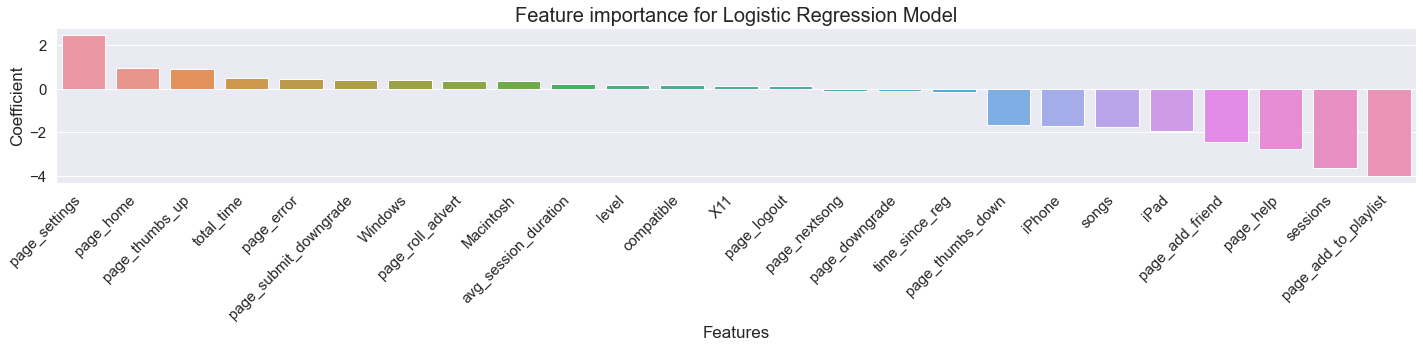

In [111]:
def plot_feature_importance(model, feature_cols):
    """
    Plot bar chart showing the importance of features with logistic regression model. 
    """
       
    feature_coef = model.bestModel.stages[2].coefficients.values.tolist()
    feature_coef_df = pd.DataFrame(list(zip(feature_cols, feature_coef)), columns=['Feature', 'Coefficient'])\
    .sort_values('Coefficient', ascending=False)

    plt.figure(figsize=(20,5))
    sns.barplot(x='Feature', y='Coefficient', data=feature_coef_df)
    plt.title('Feature importance for Logistic Regression Model', fontsize=20)
    plt.xlabel('Features', fontsize=17)
    plt.ylabel('Coefficient', fontsize=17)
    plt.xticks(rotation=45, ha='right', fontsize=15)
    plt.yticks(fontsize=15)
    plt.tight_layout()
    plt.show()

plot_feature_importance(fit_model_tuned, user_df.columns[2:])

### Random Forest Tuning

In [127]:
rf = RandomForestClassifier(featuresCol="scaled_features", labelCol="churn")
paramGrid_rf = ParamGridBuilder()\
    .addGrid(rf.impurity,['entropy', 'gini']) \
    .addGrid(rf.maxDepth,[2, 4, 6, 8]) \
    .build()
model_tuned_rf = model_pipeline(rf, paramGrid_rf)

In [128]:
fit_model_tuned_rf = model_tuned_rf.fit(train)                                       
best_model = fit_model_tuned_rf.bestModel
best_model_pred = best_model.transform(test)

In [129]:
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction", labelCol="churn")
best_f1_score = evaluator.evaluate(best_model_pred, {evaluator.metricName: "f1"})
best_accuracy_score = evaluator.evaluate(best_model_pred, {evaluator.metricName: "accuracy"})

print("f1 using tuned RF: {}".format(best_f1_score))
print("accuracy using tuned RF: {}".format(best_accuracy_score))

f1 using tuned RF: 0.9870528518975267
accuracy using tuned RF: 0.9872611464968153


### Gradient Boost Tuning

In [119]:
gbt = GBTClassifier(featuresCol="scaled_features", labelCol="churn")
paramGrid_gbt = ParamGridBuilder()\
    .addGrid(gbt.maxDepth, [2, 4, 6, 8, 10]) \
    .build()
model_tuned_gbt = model_pipeline(gbt, paramGrid_gbt)

In [120]:
fit_model_tuned_gbt = model_tuned_gbt.fit(train)                                       
best_model = fit_model_tuned_gbt.bestModel
best_model_pred = best_model.transform(test)

In [121]:
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction", labelCol="churn")
best_f1_score = evaluator.evaluate(best_model_pred, {evaluator.metricName: "f1"})
best_accuracy_score = evaluator.evaluate(best_model_pred, {evaluator.metricName: "accuracy"})

print("f1 using tuned RF: {}".format(best_f1_score))
print("accuracy using tuned RF: {}".format(best_accuracy_score))

f1 using tuned RF: 0.9914626877232317
accuracy using tuned RF: 0.9915074309978769


###  Decision Tree Tuning

In [156]:
dt = DecisionTreeClassifier(featuresCol="scaled_features", labelCol="churn")
paramGrid_dt = ParamGridBuilder()\
    .addGrid(dt.impurity,['entropy', 'gini']) \
    .addGrid(dt.maxDepth,[2, 4, 6, 8]) \
    .build()
model_tuned_dt = model_pipeline(dt, paramGrid_dt)

In [157]:
fit_model_tuned_dt = model_tuned_dt.fit(train)                                       
best_model = fit_model_tuned_dt.bestModel
best_model_pred = best_model.transform(test)

In [158]:
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction", labelCol="churn")
best_f1_score = evaluator.evaluate(best_model_pred, {evaluator.metricName: "f1"})
best_accuracy_score = evaluator.evaluate(best_model_pred, {evaluator.metricName: "accuracy"})

print("f1 using tuned RF: {}".format(best_f1_score))
print("accuracy using tuned RF: {}".format(best_accuracy_score))

f1 using tuned RF: 0.984978734359355
accuracy using tuned RF: 0.9851380042462845


## Model Evaluation and Validation

### Tuning Results

Based on the results of Figure 8, gradient boosting classification is the best model as it has the highest f1 score of 0.9915. Gradient boosting builds trees one at a time, allowing each new tree to help correct errors made by previously trained trees. The model becomes more expressive with respect to their depth with each tree added. After performing hypertuning optimization, the best parameters by grid search is maxDepth [2, 4, 6, 8, 10] for gradient boosting and impurity [‘entropy’, ‘gini’], and maxDepth [2, 4, 6, 8] for random forest respectively.
This makes sense as increasing the depth of tree and number of trees impacts model performance in a positive manner. By performing a 2-fold cross-validation, the risk of overfitting the model was heavily reduced as well.

### Justification

Overall, the project is successful as all the necessary questions were answered. The exploratory analysis revealed common trends and features that hypothetically influenced churn rates, and the features selected for modeling were proven to be significant factors in predicting churn rate as all the important models have performed very well. The f1 score of 0.9915 for gradient boosting and 0.9871 for random forest respectively.
The f1 score is the key evaluation metric in selecting the best model as it results in low false positive and false negative values thereby reducing business costs. It also provides equal weightage to both precision and recall values and is robust measure in comparison to other metrics.

## Conclusion

### Reflection

The objective was to predict users who may potentially churn in the digital music service named Sparkify. Any user who decided to cancel their subscription were identified as a ‘churned’ user.

Key steps:

1. Perform exploratory analysis to gain a deeper understanding of the distribution of users based on features such as gender, page activity, device, location, etc.
2. The insights from the analysis and other key features were hypothetically selected to perform feature engineering, creating a data frame ready for modeling.
3. The data was split into — train (70%) and test datasets (30%) for model building and evaluation.
4. Machine learning pipelines for several classifiers were performed along with hypertuning grid search parameters to further optimize results.
5. Gradient Boosting was selected as the best model based on the metric f1- score after using a 2-fold cross validation method on test dataset.

Due to the great model performance, I wouldn’t try any other model. Rather, I would add new aspects to the existing analysis such as adding a feature ranking to the analysis so that we could gain insights into how important each feature is for predictive performance. The feature importance score returned by the prediction model can be used to identify the cause of churn and Sparkify can make improvements of these causes. There could be several ways to tweak the model involving a largest dataset such as the features to engineer, which model and hyperparameters to tune in training.

### Improvements

There are a couple of potential improvements in future:

1. Collect more user data

We can create various metrics such as — number of times user logged in by month, number of times user upgraded or downgraded their services, and add demographic information to improve the accuracy of model prediction.

2. The XGBoost and LightGBM models could be good supervised learning approaches to try here. Another way is to perform A/B testing to select which action to take.

3. Build a Recommendation Engine.

By collecting additional data as mentioned above, building a recommendation engine using collaborative filtering where we could identify user similarity between other users based on the type of songs/artists/genres they enjoy, and provide personalized recommendations regarding songs/artists they may like to improve user experience with the app.
